### Importing the required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"]=(20,10)

### Importing the dataset

In [3]:
X_train = np.loadtxt("X_train.txt")
X_val = np.loadtxt("X_val.txt")
y_val = np.loadtxt("y_val.txt")

In [4]:
print("The first 5 elements of X_train are:\n", X_train[:5])

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [5]:
print("The first 5 elements of y_val are\n", y_val[:5]) 
y_val = y_val.astype(int)

The first 5 elements of y_val are
 [0. 0. 0. 0. 0.]


In [6]:
X_val[:5]

array([[15.79025979, 14.9210243 ],
       [13.63961877, 15.32995521],
       [14.86589943, 16.47386514],
       [13.58467605, 13.98930611],
       [13.46404167, 15.63533011]])

In [7]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


In [8]:
a = [i[0] for i in X_train]
b = [i[1] for i in X_train]

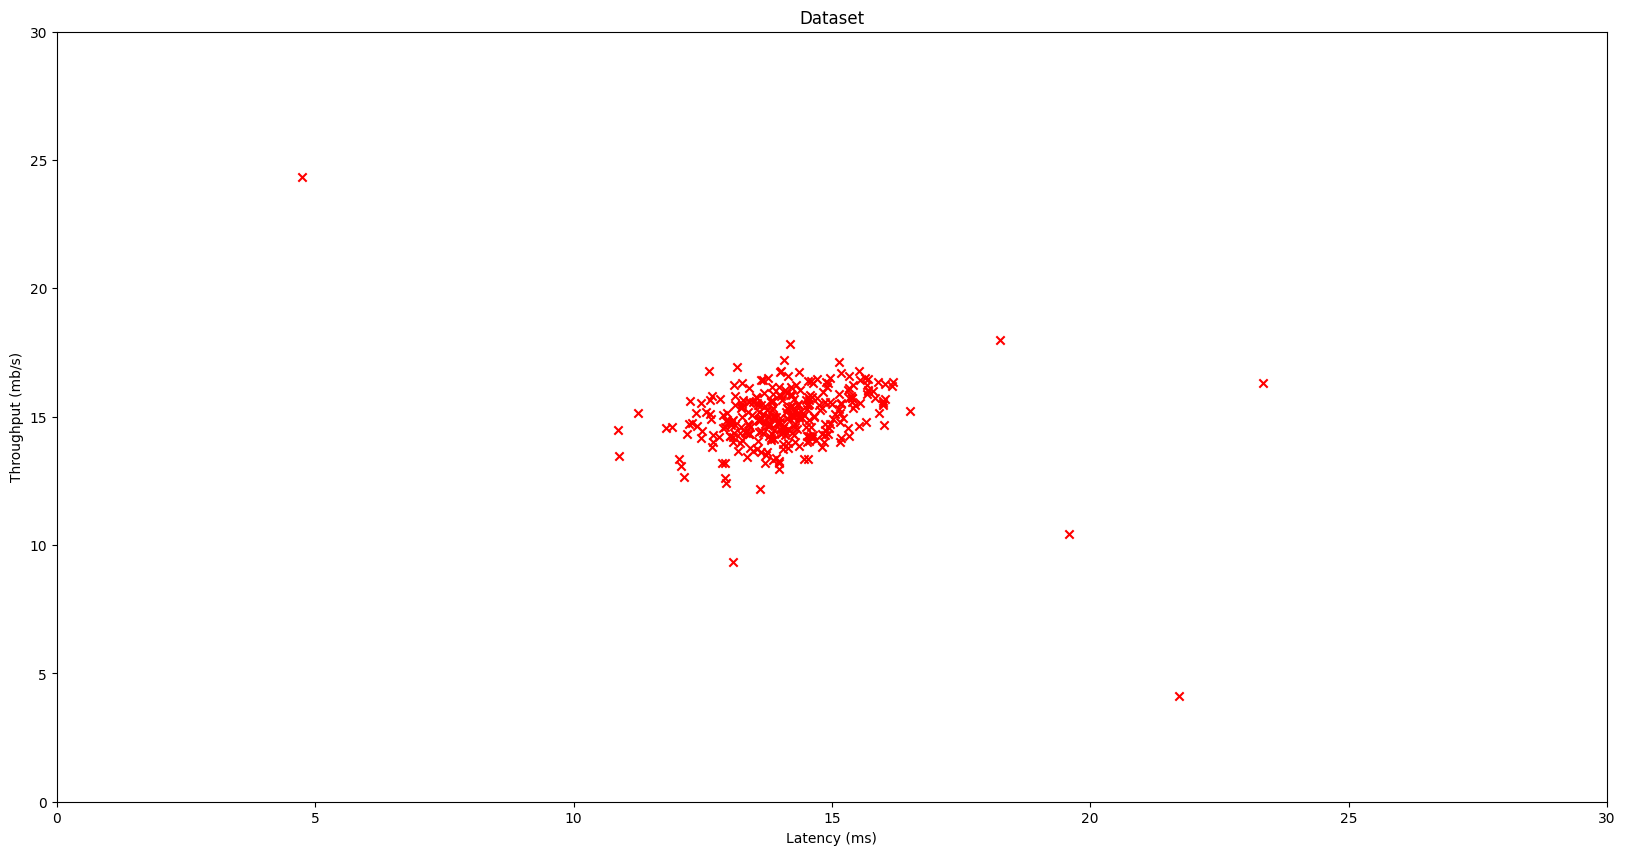

In [9]:
# Create a scatter plot of the data. To change the markers to blue "x",
# we used the 'marker' and 'c' parameters
plt.scatter(a, b, marker='x', c='r') 

# Set the title
plt.title("Dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

In [10]:
def estimate_gaussian(X):
    m, n = X.shape
    mu=(1/m)*(np.sum(X,axis=0))
    var=(1/m)*(np.sum((X-mu)**2,axis=0))

    return mu, var

In [11]:
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]


In [12]:
def multivariate_gaussian(X, mu, var):
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

In [23]:
def visualize_fit(X, mu, var):
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'rx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

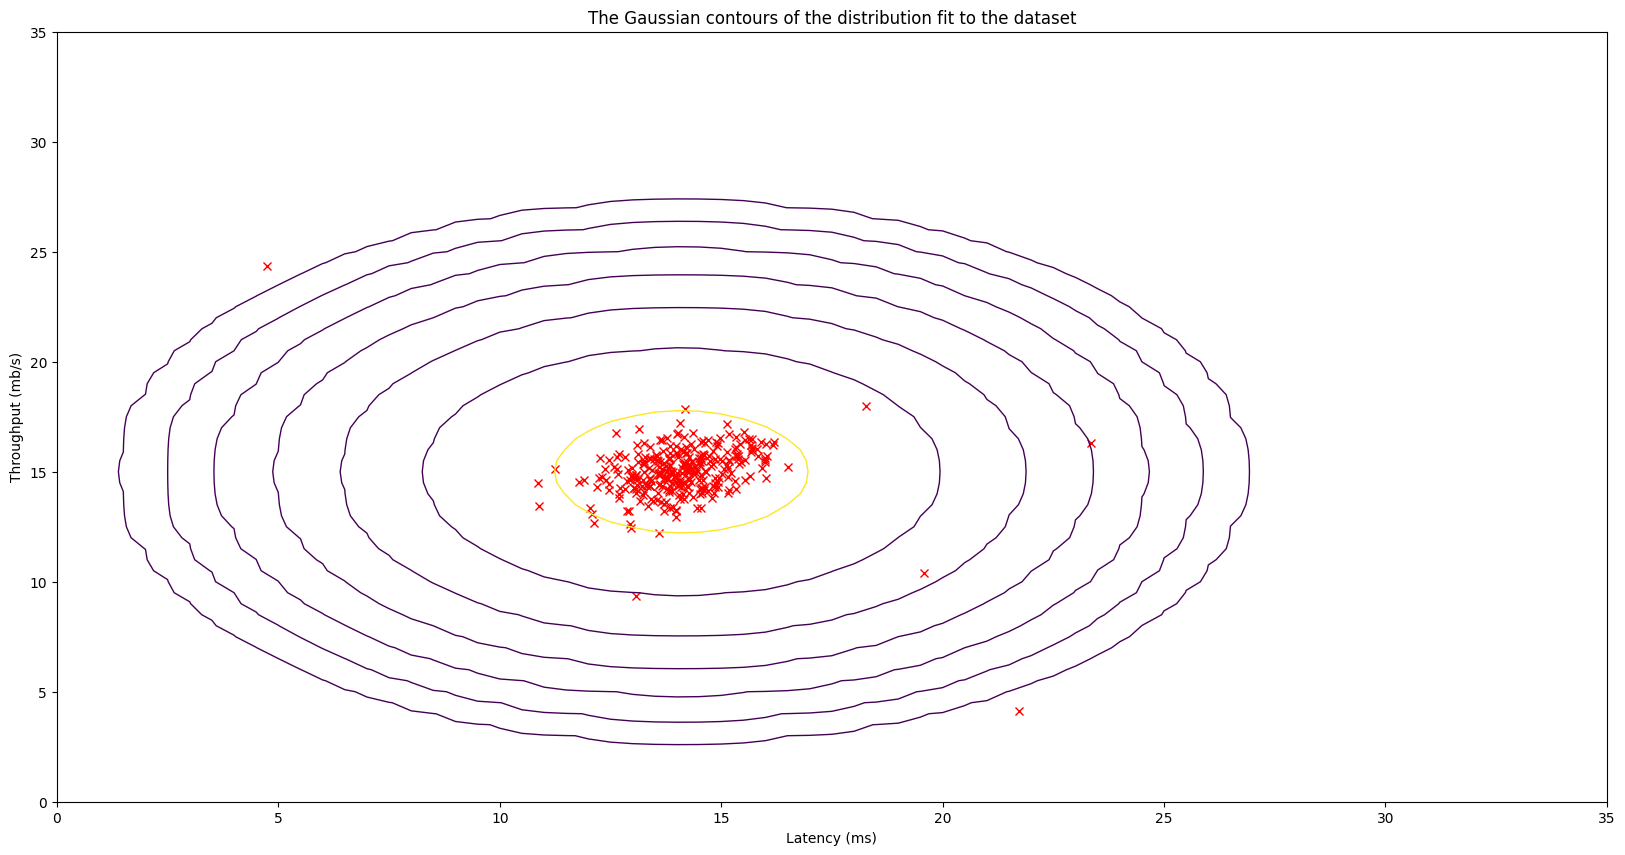

In [24]:
p = multivariate_gaussian(X_train, mu, var)

#Plotting code
visualize_fit(X_train, mu, var)

In [15]:
def select_threshold(y_val, p_val): 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions=(p_val<epsilon)
        
        tp=np.sum((predictions==1) & (y_val==1))
        fp=np.sum((predictions==1) & (y_val==0))
        fn=np.sum((predictions==0) & (y_val==1))
        
        prec=tp/(tp+fp)
        recall=tp/(tp+fn)
        F1=(2*prec*recall)/(prec+recall)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [16]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using test data: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using test data: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


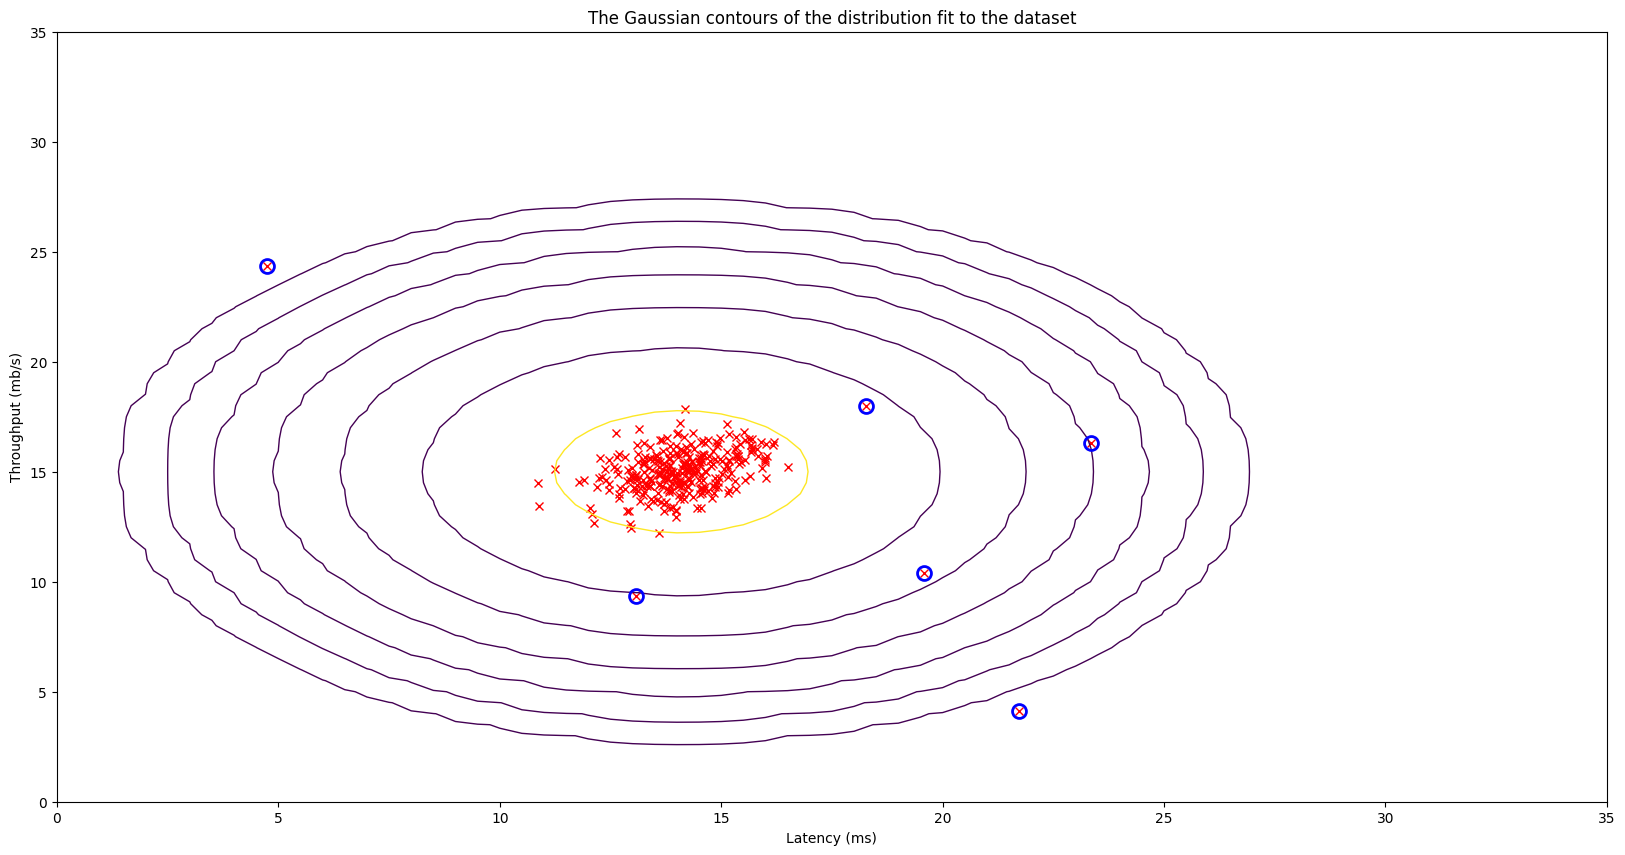

In [25]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)
# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'bo',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

In [28]:
from sklearn.ensemble import IsolationForest

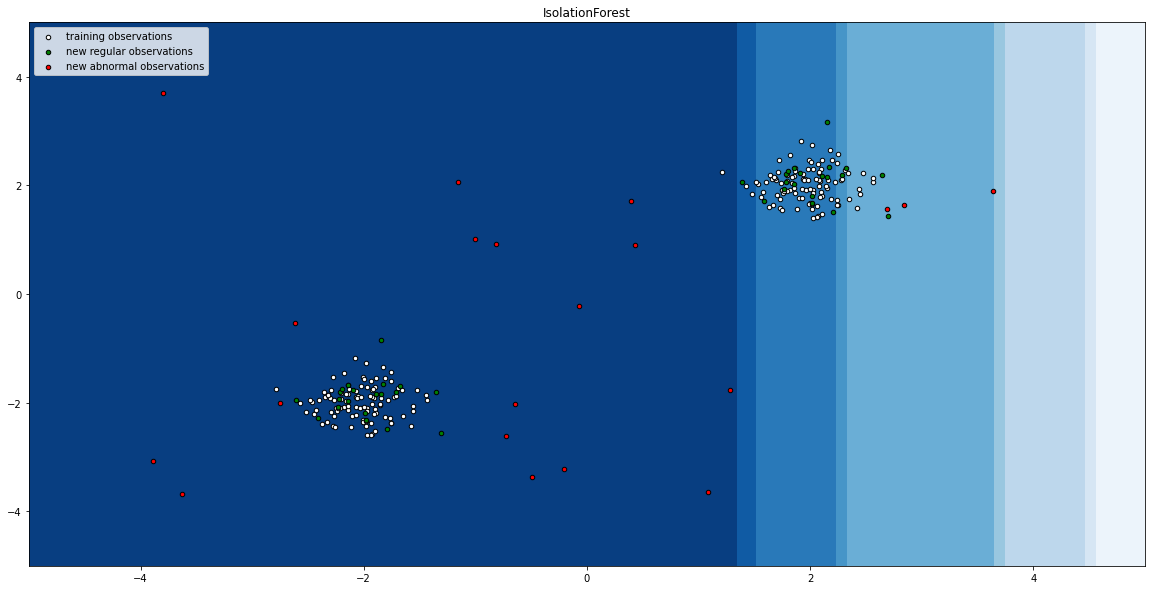

In [ ]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_val)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="upper left",
)
plt.show()

In [ ]:
clf = IsolationForest()
clf.fit(X_train)

IsolationForest()

In [ ]:
predicted = clf.predict(X_val)

incrt_predict = 0

for j in range(X_val.shape[1]):
    if(1-predicted[j] != y_val[j]):
        incrt_predict += 1

print(f" Incorrect Predictions : {incrt_predict}")

 Incorrect Predictions : 2


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

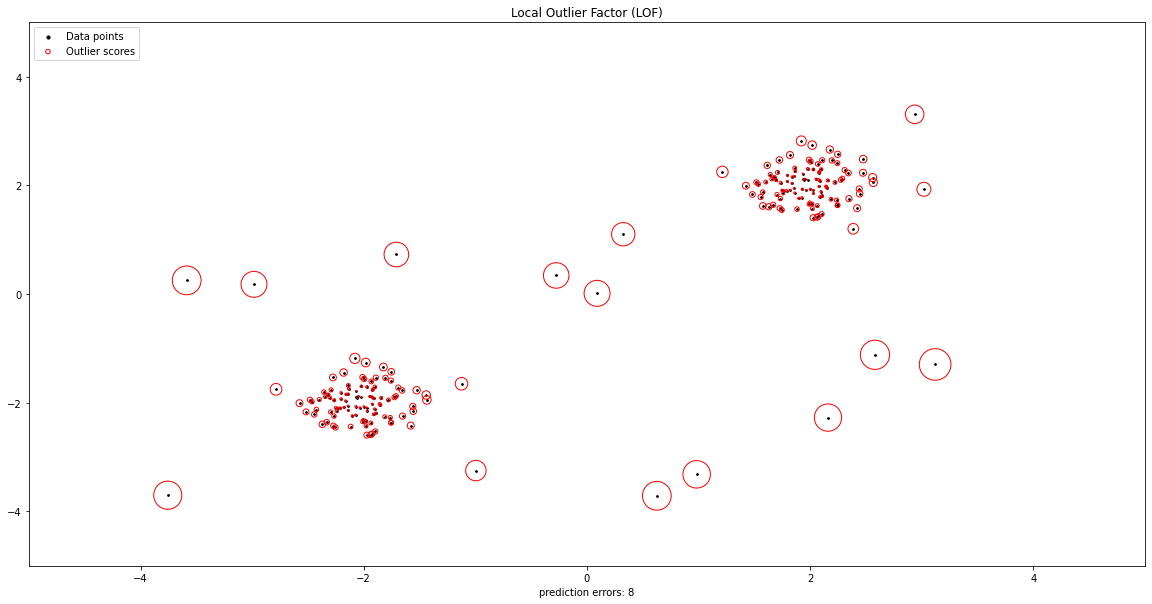

In [ ]:

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [ ]:
clf = LocalOutlierFactor(n_neighbors=2)
predicted = clf.fit_predict(X_val)

In [ ]:
incrt_predict = 0

for j in range(X_val.shape[1]):
    if(1-predicted[j] != y_val[j]):
        incrt_predict += 1

print(f" Incorrect Predictions : {incrt_predict}")

 Incorrect Predictions : 0
